# GAN Generative Dog Images

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import matplotlib.pyplot as plt # to show images

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
from tensorflow.keras.preprocessing.image import img_to_array
import os
import time
import tensorflow as tf

In [23]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print("available gpu: {}".format(get_available_gpus()))
print("tensorflow version: {}".format(tf.__version__))

available gpu: ['/device:GPU:0']
tensorflow version: 2.1.0-rc0


# Load and Preprocess Image

In [24]:
IMAGE_DIR = '/kaggle/input/stanford-dogs-dataset/images/Images'
ANNOTATION_DIR = '/kaggle/input/stanford-dogs-dataset/annotations/Annotation'

IMG_WIDTH = 64
IMG_HEIGHT = 64

def bounding_box(label, image_name):
    image_name = image_name.split(".")[0]
    annotation_path = os.path.join(ANNOTATION_DIR, label, image_name)
    
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
    return (xmin,ymin,xmax,ymax)

def decode_image(img_path, bbox):

    img = Image.open(img_path)
    img = img.crop(bbox)
    
    img = tf.keras.preprocessing.image.img_to_array(img)
    # resize the image to the desired size.
    img = tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
    
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    img = (img / 127.5) - 1
    
    return img

def plot_images(images):
    plt.figure(figsize=(10,10))
    
    for i, image in enumerate(images):
        plt.subplot(5, 5, i+1)
        plt.imshow(image, interpolation='nearest')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

In [25]:
images = []

for dirname, _, filenames in os.walk(IMAGE_DIR):
    label = dirname.split("/")[-1]
    
    for image_name in filenames:
        xmin,ymin,xmax,ymax = bounding_box(label, image_name)
    
        xdelta = xmax - xmin
        ydelta = ymax - ymin
    
        if xdelta < IMG_WIDTH or ydelta < IMG_HEIGHT:
            continue
        
        image = decode_image(os.path.join(IMAGE_DIR, label, image_name), (xmin,ymin,xmax,ymax))
    
        if image.shape[-1] != 3:
            continue
    
        images.append(image)

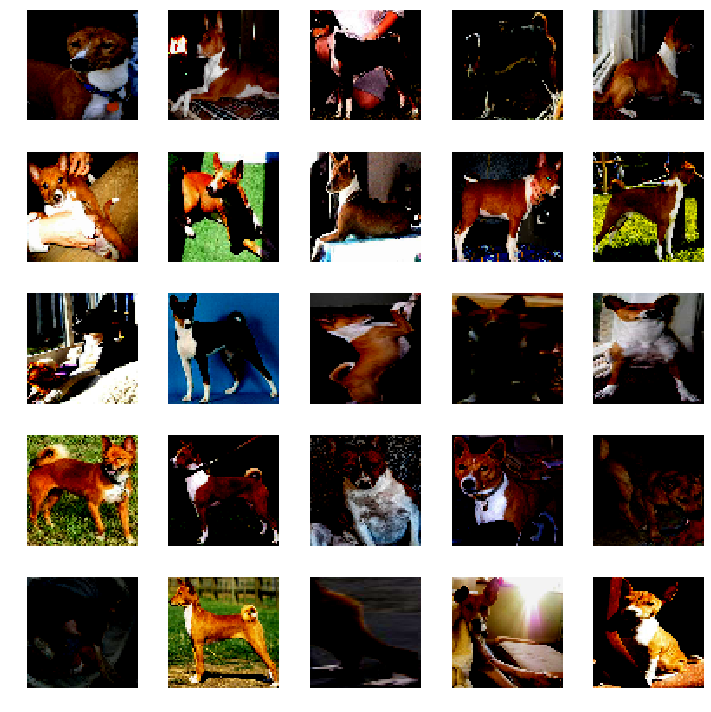

In [26]:
plot_images(images[1000:1025])

## Tensorflow dataset

In [27]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32
images = tf.cast(images, 'float32')

dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset

<BatchDataset shapes: (None, 64, 64, 3), types: tf.float32>

# Model

## Generator

In [28]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(512 * 8 * 8, input_dim=100 ))
    model.add(tf.keras.layers.Reshape((8, 8, 512)))
    
    model.add(tf.keras.layers.Conv2DTranspose(512, (4,4), strides=(1,1), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-05))
    
    model.add(tf.keras.layers.Conv2DTranspose(256, (4,4), strides=(2,2), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-05))

    model.add(tf.keras.layers.Conv2DTranspose(128, (4, 4),strides=(2,2), activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-05))
    
    model.add(tf.keras.layers.Conv2DTranspose(64, (4, 4), strides=(2,2),activation='relu', padding='same'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.1, epsilon=1e-05))
    
    model.add(tf.keras.layers.Conv2DTranspose(3, (4,4), strides=(1,1), activation='tanh', padding='same'))
    
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))

    return model

generator = make_generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         4194816   
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 256)       2097408   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 128)      

## Discriminator

In [29]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(64, (4,4), strides=(2,2), padding='same', input_shape=[64, 64, 3]))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    model.add(tf.keras.layers.Conv2D(128, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    model.add(tf.keras.layers.Conv2D(256, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    model.add(tf.keras.layers.Conv2D(512, (4,4), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    
    model.add(tf.keras.layers.Conv2D(1, (4,4), strides=(1,1), padding='same'))

    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5))
    return model

discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         524544    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 512)        

## GAN

In [30]:
gan = tf.keras.Sequential([generator, discriminator])
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
gan.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 64, 64, 3)         10264259  
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 2764754   
Total params: 13,029,013
Trainable params: 10,262,339
Non-trainable params: 2,766,674
_________________________________________________________________


# Training

## Plotting

In [41]:
def plot_loss(epoch, d_losses, g_losses):
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss, Epochs 0-" + str(epoch))
    plt.plot(g_losses,label="G")
    plt.plot(d_losses,label="D")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig('/kaggle/working/images/img_' + str(epoch) + '.png')
    plt.show()

def generate_and_save_images(model, epoch, test_input):
    predictions = model.predict(test_input)

    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(5, 5, i+1)
        
        image = (predictions[i] + 1)*127.5
        image = image.astype(np.uint8)
        
        plt.imshow(image, interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('/kaggle/working/figures/loss_' + str(epoch) + '.png')
    plt.show()

In [55]:
EPOCHS = 400
batches = int(len(images) / BATCH_SIZE)

noise_dim = 100
num_examples_to_generate = 25
discriminator_loss, generator_loss = [], []

seed = tf.random.normal([num_examples_to_generate, noise_dim])
generator, discriminator = gan.layers

def train_step(image_batch):
    batch_size = image_batch.shape[0]
    
    noise = tf.random.normal([batch_size, noise_dim])
    generated_images = generator(noise)

    X_fake_and_real = tf.concat([generated_images, image_batch], axis=0)
    
    y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
    
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X_fake_and_real, y1)
    
    # phase 2
    noise = tf.random.normal([batch_size, noise_dim])
    y2 = tf.constant([[1.]] * batch_size)
    
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y2)
    
    return d_loss, g_loss

def train(dataset, epochs):
    start = time.time()
    
    for epoch in range(epochs):
        epoch_start = time.time()
        
        g_total_loss = 0; d_total_loss = 0
        
        for image_batch in dataset:
            d_loss, g_loss = train_step(image_batch)
            
            d_total_loss += d_loss
            g_total_loss += g_loss
        
        d_epoch_loss = d_total_loss/batches
        g_epoch_loss = g_total_loss/batches
        
        discriminator_loss.append(d_epoch_loss)
        generator_loss.append(g_epoch_loss)
        
        
        if epoch > 0 and epoch % 40 == 0:
            print('Epoch={} Discriminator Loss={} Generator Loss={} Time={} sec'.format(epoch, d_epoch_loss, g_epoch_loss, time.time() - epoch_start))
            
            plot_loss(epoch, discriminator_loss, generator_loss)
            generate_and_save_images(generator, epoch, seed)
            
    print('Total Time for epochs {} is {} sec'.format(epochs, time.time() - start))
        

Epoch=40 Discriminator Loss=0.18645913718519352 Generator Loss=5.642337707890238 Time=44.39846634864807 sec


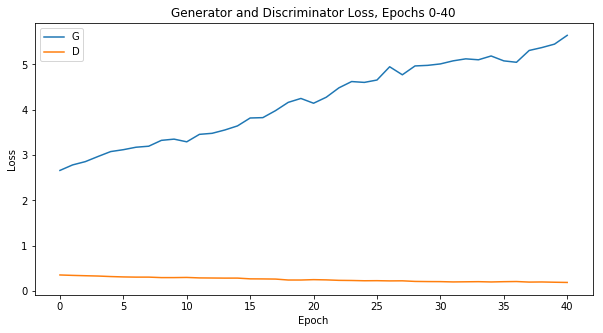

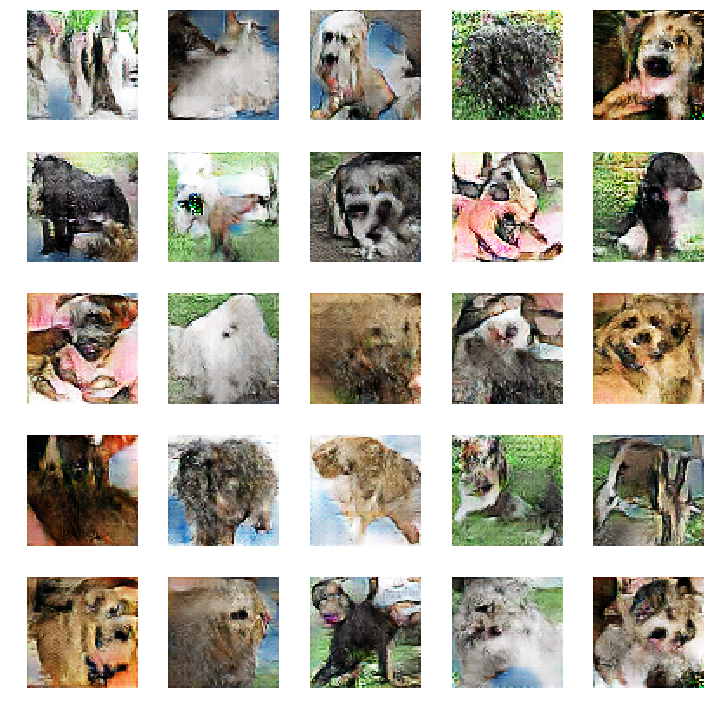

Epoch=80 Discriminator Loss=0.1563945165666537 Generator Loss=7.442541130704566 Time=44.4879937171936 sec


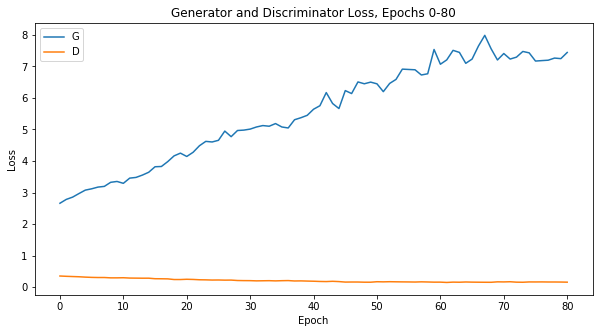

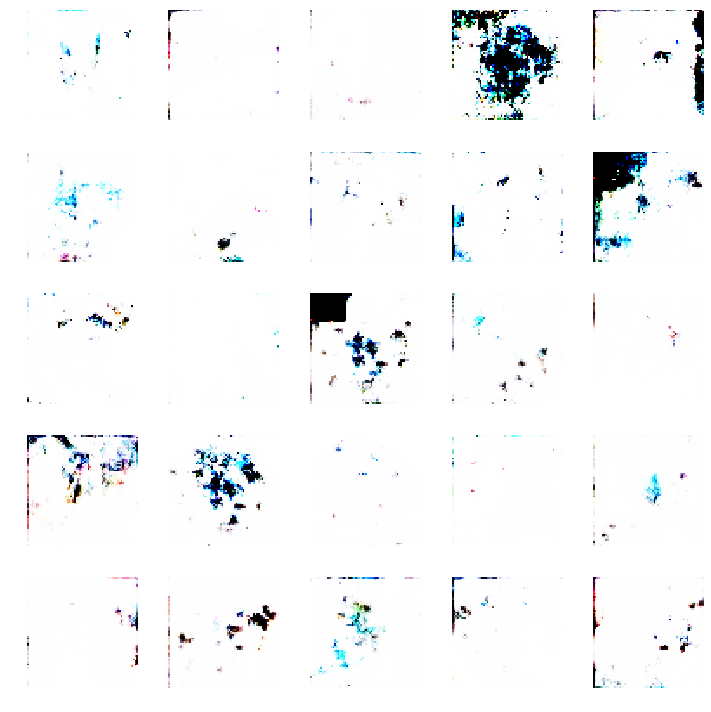

Epoch=120 Discriminator Loss=0.14119594189160295 Generator Loss=8.434465498012434 Time=44.5050835609436 sec


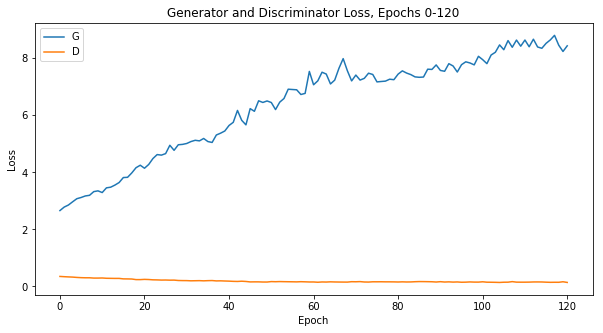

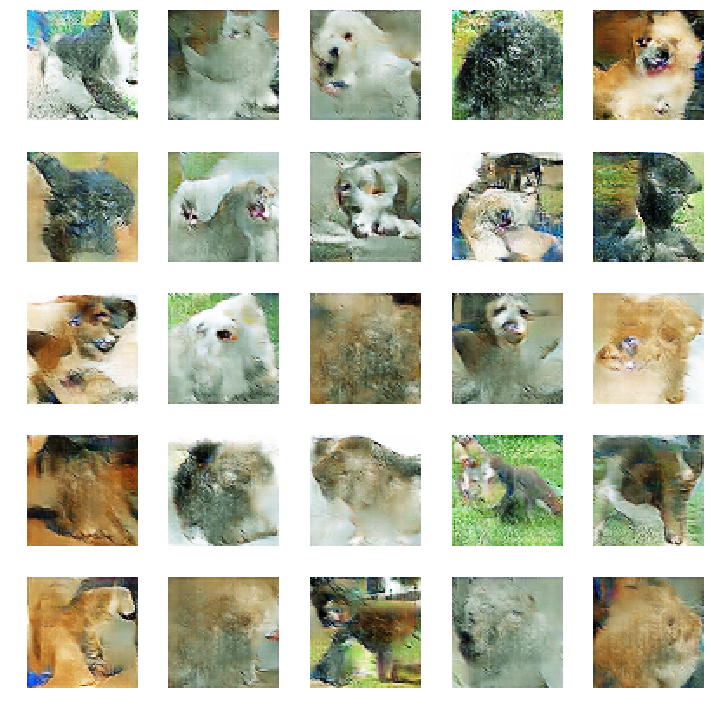

Epoch=160 Discriminator Loss=0.1450734875478043 Generator Loss=9.940711181365584 Time=44.533766746520996 sec


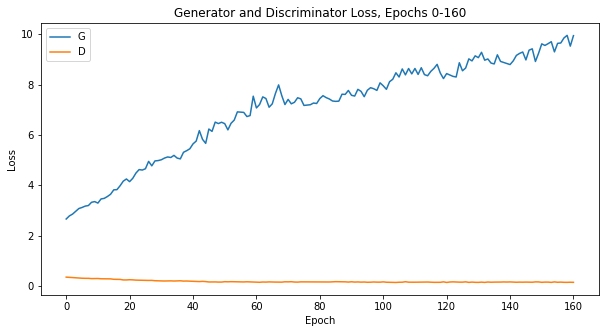

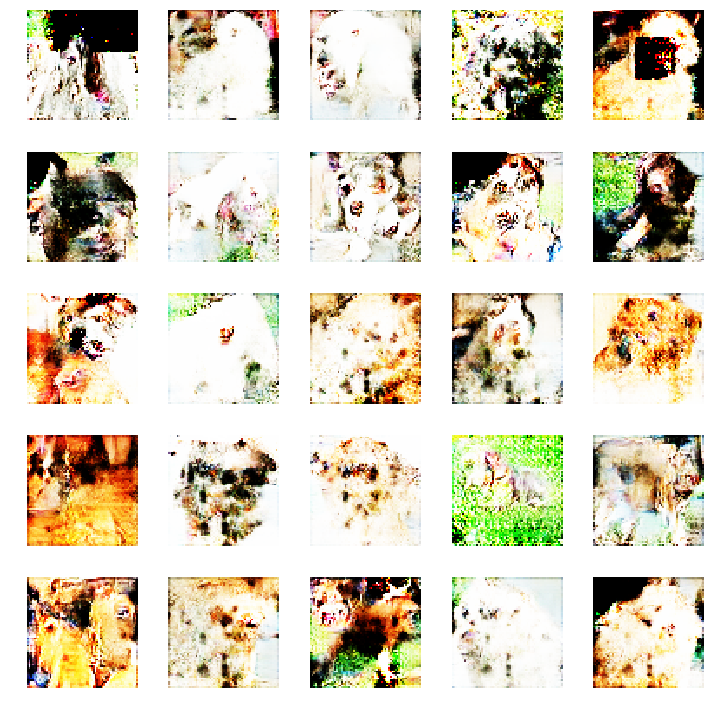

Epoch=200 Discriminator Loss=0.15131022031901611 Generator Loss=11.553860810109441 Time=44.536182165145874 sec


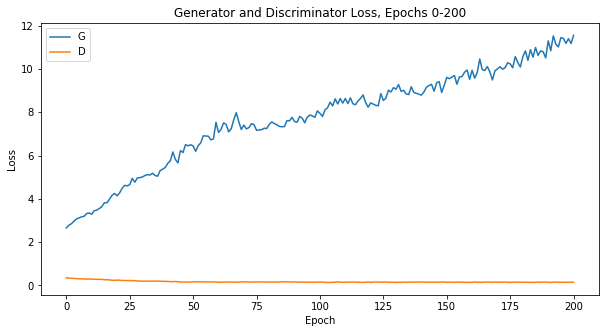

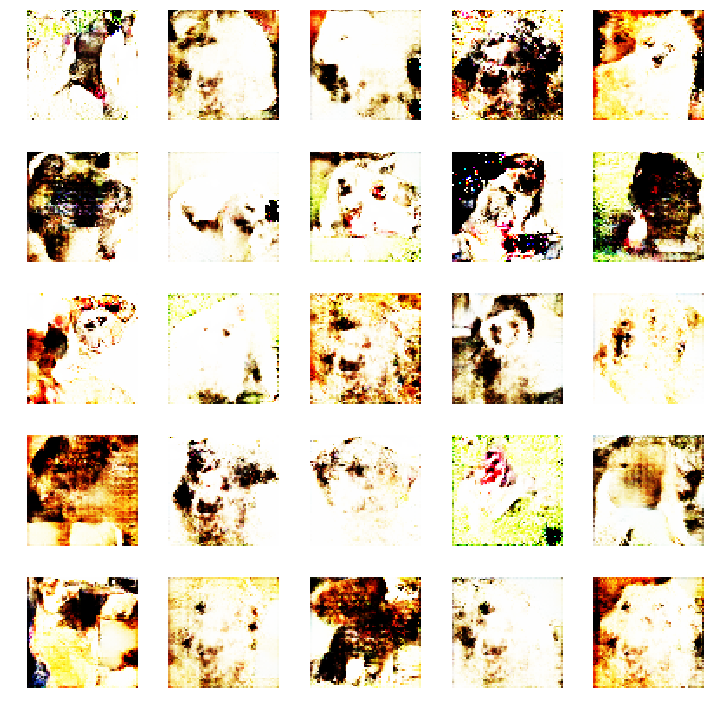

Epoch=240 Discriminator Loss=0.1587148875048142 Generator Loss=13.18268251568546 Time=44.827115297317505 sec


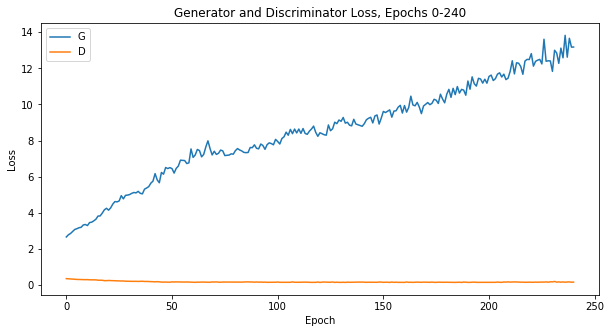

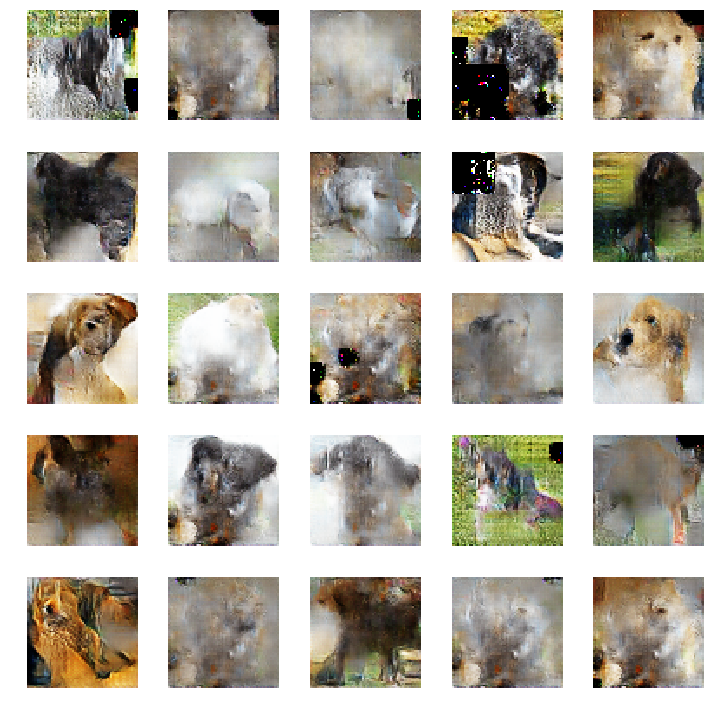

Epoch=280 Discriminator Loss=0.1680773590944804 Generator Loss=17.37199499390342 Time=45.38796806335449 sec


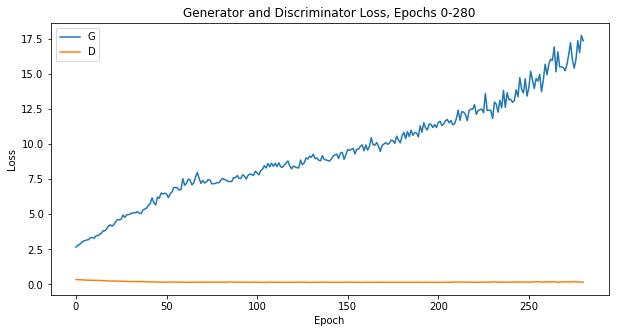

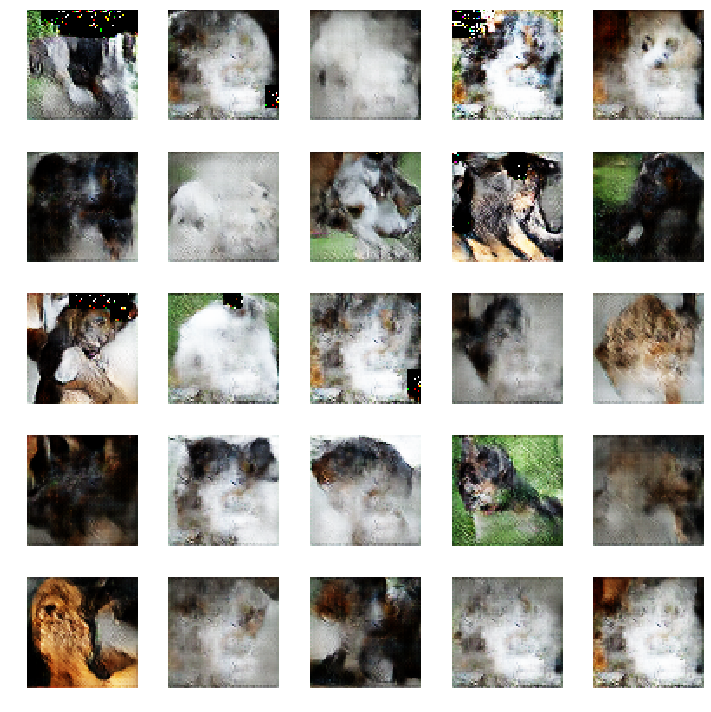

Epoch=320 Discriminator Loss=0.20826048127335395 Generator Loss=21.476746278870444 Time=45.55885124206543 sec


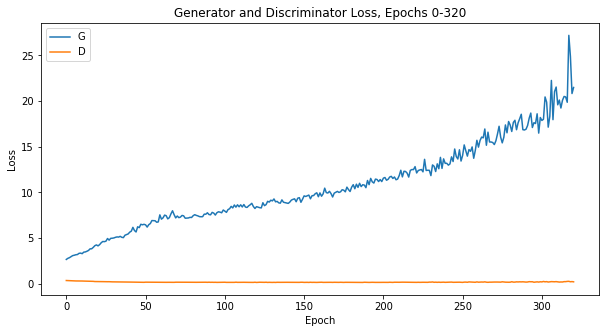

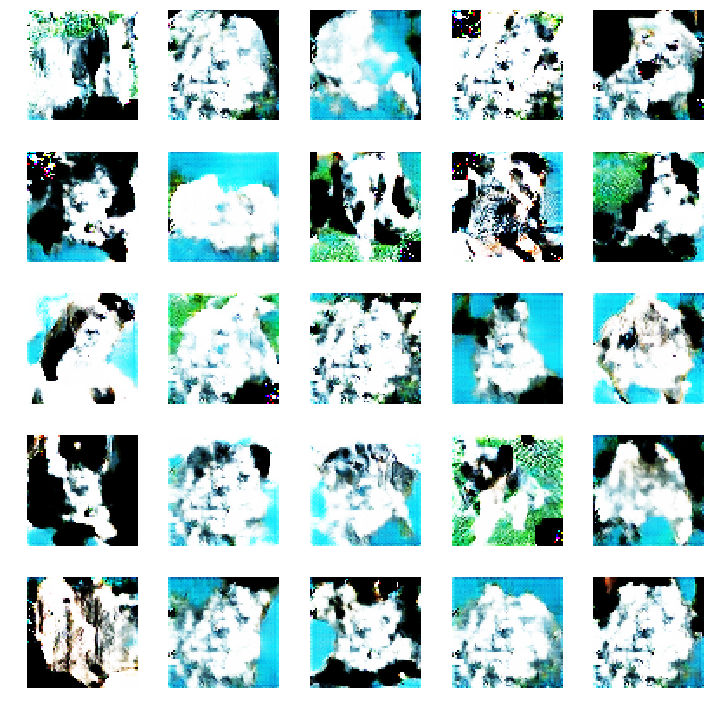

Epoch=360 Discriminator Loss=0.3644307470527818 Generator Loss=41.6908826581363 Time=44.867656230926514 sec


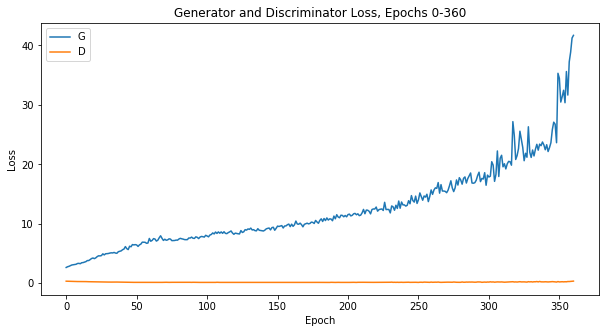

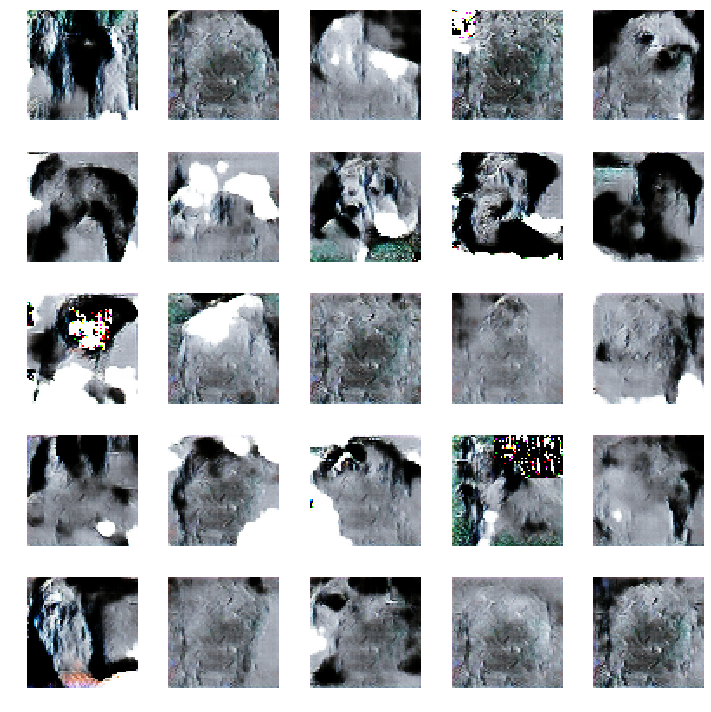

Total Time for epochs 400 is 17950.566833496094 sec


In [56]:
#train(dataset, EPOCHS)